# Classifying NC vs PAE - Pre-trained SFCN Model - Using Processed MRI

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nibabel as nib
from scipy.stats import norm
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from monai.data import Dataset, ArrayDataset, DataLoader
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, AddChanneld, RandRotated, Lambda, ToTensor

In [2]:
# Keeping all file names in the list.
NC_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\NC_Resized_122_MRI"
PAE_MRI_path = r"C:\Users\anikd\Desktop\NC_vs_PAE\Resized_MRI\PAE_Resized_MRI"

in_X = []
out_y = []

for file_name in os.listdir(NC_MRI_path):
    in_X.append(NC_MRI_path + "/" + file_name)
    out_y.append(0)
    
for file_name in os.listdir(PAE_MRI_path):
    in_X.append(PAE_MRI_path + "/" + file_name)
    out_y.append(1)
    
print(len(in_X), len(out_y))

244 244


In [3]:
X = []
y = []

for i in range(0, len(in_X), +1):
    mri = nib.load(in_X[i])
    data = mri.get_fdata()
    
    # Adding an extra dimension at the begining. From (160,192,160) to (1,160,192,160).
    data = data[np.newaxis, ...]
    
    X.append(data)
    y.append(out_y[i])
    
# Converting to numpy array.   
X = np.array(X)
y = np.array(y)

print(X[0].shape)
print(y[0].shape)

(1, 160, 192, 160)
()


# Simple Fully Convolutional Network (SFCN) Architecture

In [4]:
class SFCN(nn.Module):
    def __init__(self, channel_number):  # channel_number = [28, 58, 128, 256, 256, 64]
        super(SFCN, self).__init__()
        
        n_layer = len(channel_number)
        
        self.feature_extractor = nn.Sequential()
        
        for i in range(n_layer):
            if i == 0:
                in_channel = 1
            else:
                in_channel = channel_number[i-1]
                
            out_channel = channel_number[i]
            
            if i < n_layer-1:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 1))
            else:
                self.feature_extractor.add_module('conv_%d' % i, self.conv_layer(in_channel, out_channel, maxpool = False, kernel_size = 1, padding = 0))
    
    
    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool = True, kernel_size = 3, padding = 0, maxpool_stride = 2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU(),
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding = padding, kernel_size = kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer
    

    def forward(self, input_image):
        extracted_features = self.feature_extractor(input_image) 
        
        return extracted_features   #shape: [64,5,6,5]
    

channel_number = [28, 58, 128, 256, 256, 64] # Sex-prediction
#channel_number = [32, 64, 128, 256, 256, 64] # Brain-Age-prediction

model = SFCN(channel_number)

# Loading pre-trained model - Removing weights and biases for Classification Part

In [5]:
tm = "BSP_run_20191008_00_epoch_last.p" # Pre-trained model aka weights and biases of already trained model for sex prediction.
#tm = "BAP_run_20190719_00_epoch_best_mae.p" # This is for Brain Age prediction.
state_dict = torch.load(tm)

for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [6]:
# Removing weight and bias (parameters) of classifier layer.
state_dict.pop('module.classifier.conv_6.weight', None)
state_dict.pop('module.classifier.conv_6.bias', None)

tensor([ 0.0604, -0.0605], device='cuda:0')

In [7]:
# Printing weights and biases parameter shape after removing classifier.
for name, param in state_dict.items():
    print(name, param.shape)

module.feature_extractor.conv_0.0.weight torch.Size([28, 1, 3, 3, 3])
module.feature_extractor.conv_0.0.bias torch.Size([28])
module.feature_extractor.conv_0.1.weight torch.Size([28])
module.feature_extractor.conv_0.1.bias torch.Size([28])
module.feature_extractor.conv_0.1.running_mean torch.Size([28])
module.feature_extractor.conv_0.1.running_var torch.Size([28])
module.feature_extractor.conv_0.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_1.0.weight torch.Size([58, 28, 3, 3, 3])
module.feature_extractor.conv_1.0.bias torch.Size([58])
module.feature_extractor.conv_1.1.weight torch.Size([58])
module.feature_extractor.conv_1.1.bias torch.Size([58])
module.feature_extractor.conv_1.1.running_mean torch.Size([58])
module.feature_extractor.conv_1.1.running_var torch.Size([58])
module.feature_extractor.conv_1.1.num_batches_tracked torch.Size([])
module.feature_extractor.conv_2.0.weight torch.Size([128, 58, 3, 3, 3])
module.feature_extractor.conv_2.0.bias torch.Size([128]

In [8]:
# Loading after removing the classificaiton part
model.load_state_dict(state_dict, strict = False)
model

SFCN(
  (feature_extractor): Sequential(
    (conv_0): Sequential(
      (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_1): Sequential(
      (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_2): Sequential(
      (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
    (conv_3): Seque

# Freezing Feature Extraction Layers of Pre-trained SFCN Model

In [9]:
for param in model.parameters():
    param.requires_grad = False

# Adding a Classification Layer on Top of SFCN Architecture

In [10]:
def create_model():
    # Number of node in the final layer
    num_classes = 1

    # Defining the modified model by adding layers
    modified_model = nn.Sequential(
        model, # pre-trained SFCN model (feature extractor) for feature extraction
        nn.Flatten(),
        nn.Linear(9600, 512),  # number of output features from the pre-trained model: 64*5*6*5 = 9600
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes),
        nn.Sigmoid()  # Using Sigmoid activation for binary classification
    )
    
    return modified_model

modified_model = create_model()
modified_model

Sequential(
  (0): SFCN(
    (feature_extractor): Sequential(
      (conv_0): Sequential(
        (0): Conv3d(1, 28, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_1): Sequential(
        (0): Conv3d(28, 58, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ReLU()
      )
      (conv_2): Sequential(
        (0): Conv3d(58, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

# Creating Dataset, Dataloader -- 5-Fold Train-Val-Test

In [11]:
# 5-Fold cross-validation method to train, validate and test the model
n_folds = 5
skf = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)

# Initializing list to keep info of each fold
train_loss_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []

# Initializing lists to store results for all folds
all_true_labels = []
all_predicted_labels = []
fold_sensitivities = []
fold_specificities = []
    
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}:\n")
    
    # Creating train, val, test dataset
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=fold+1)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=fold+1)
    
    train_data_dict = [{"mri": a, "label": b} for a, b in zip(X_train, y_train)]
    val_data_dict = [{"mri": a, "label": b} for a, b in zip(X_val, y_val)]
    test_data_dict = [{"mri": a, "label": b} for a, b in zip(X_test, y_test)]
    
    train_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            RandRotated(keys=["mri"], prob=1),
            ToTensor()
        ])

    val_test_transforms = Compose(
        [
            EnsureChannelFirstd(keys=["mri"], channel_dim=0),  # Ensuring a channel at the beginning
            Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
            ToTensor()
        ])

    train_dataset = Dataset(train_data_dict, train_transforms)
    val_dataset = Dataset(val_data_dict, val_test_transforms)
    test_dataset = Dataset(test_data_dict, val_test_transforms)

    
    train_count_zero = len(y_train) - np.count_nonzero(y_train)
    train_count_one = np.count_nonzero(y_train)
    val_count_zero = len(y_val) - np.count_nonzero(y_val)
    val_count_one = np.count_nonzero(y_val)
    test_count_zero = len(y_test) - np.count_nonzero(y_test)
    test_count_one = np.count_nonzero(y_test)
    
    print("NC and PAE ratio in training dataset: ", [train_count_zero, train_count_one])
    print("NC and PAE ratio in validation dataset: ", [val_count_zero, val_count_one])
    print("NC and PAE ratio in testing dataset: ", [test_count_zero, test_count_one])
    print("\n")
    
    # create the datasets and dataloaders
    #train_dataset = Creating_Dataset(X_train, y_train)
    #val_dataset = Creating_Dataset(X_val, y_val)
    #test_dataset = Creating_Dataset(X_test, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Initializing model. Need to initialize the model for each fold.
    modified_model = create_model()

    # Defining the loss function, optimizer, and metrics
    loss_fn = nn.BCELoss() #for sigmoind, output channel = 1
    optimizer = torch.optim.Adam(modified_model.parameters(), lr=0.001)
    
    # Creating list to keep loss and acc for each epoch
    train_loss_100epochs = []
    val_loss_100epochs = []
    test_acc_100epochs = []
    
    # Initializing lists to store results for each epoch in the fold
    fold_true_labels = []
    fold_predicted_labels = []

    num_epochs = 100

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        ############### Training on Train Set ###############
        modified_model.train()
        modified_model.cuda()

        for train_batch_idx, train_batch_data in enumerate(train_dataloader):
            train_input, train_actual_output = train_batch_data["mri"], train_batch_data["label"]
                                    
            train_input = train_input.cuda()
            train_actual_output = train_actual_output.cuda()

            optimizer.zero_grad()
            
            # Forward pass
            train_pred_output = modified_model(train_input)
            loss = loss_fn(train_pred_output, train_actual_output)

            # Backward and optimize
            loss.backward()
            train_loss = train_loss + loss.item()
            optimizer.step()

        train_loss = train_loss / (train_batch_idx + 1)

        ############### Evaluating on Validation Set ###############
        with torch.no_grad():
            modified_model.eval()
            modified_model.cuda()
            
            for val_batch_idx, val_batch_data in enumerate(val_dataloader):
                val_input, val_actual_output = val_batch_data["mri"], val_batch_data["label"]
                
                val_input = val_input.cuda()
                val_actual_output = val_actual_output.cuda()

                val_pred_output = modified_model(val_input)
                loss = loss_fn(val_pred_output, val_actual_output)
                val_loss = val_loss + loss.item()

            val_loss = val_loss / (val_batch_idx + 1)
        
        ############### Testing on Test Set ###############
        with torch.no_grad():
            total_sample = 0
            test_accuracy_total = 0

            for test_batch_data in test_dataloader:
                test_input, test_actual_output = test_batch_data["mri"], test_batch_data["label"]
                
                test_input = test_input.cuda()
                test_actual_output = test_actual_output.cuda()

                test_pred_output = modified_model(test_input)
                test_pred_output = torch.round(test_pred_output)
                
                # Append true and predicted labels for each sample in the test set
                fold_true_labels.extend(test_actual_output.cpu().numpy())
                fold_predicted_labels.extend(test_pred_output.cpu().numpy())

                # Calculating accuracy
                total_sample += test_actual_output.size(0)
                test_accuracy_total += (test_pred_output == test_actual_output).sum().item()

            accuracy = 100 * test_accuracy_total / total_sample

        train_loss_100epochs.append(train_loss)
        val_loss_100epochs.append(val_loss)
        test_acc_100epochs.append(accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(epoch+1, train_loss, val_loss, accuracy))
    
    # Keeping loss for each fold. Each fold has the loss for 100 epochs.
    train_loss_per_fold.append(train_loss_100epochs)
    val_loss_per_fold.append(val_loss_100epochs)
    
    # Keeping the Average accuracy for each fold. (sum of 100 epochs accuracy / 100 epochs)
    test_acc_per_fold.append(np.mean(test_acc_100epochs))
    
    # Calculate confusion matrix, sensitivity, and specificity for the current fold
    fold_confusion_matrix = confusion_matrix(fold_true_labels, fold_predicted_labels)
    tn, fp, fn, tp = fold_confusion_matrix.ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print or store the results for the current fold
    print(f'Fold {fold+1} - Sensitivity: {sensitivity}, Specificity: {specificity}')

    # Append the true and predicted labels for the current fold to the overall lists
    all_true_labels.extend(fold_true_labels)
    all_predicted_labels.extend(fold_predicted_labels)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)
    
# Concatenate the confusion matrices from all folds
all_confusion_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
tn, fp, fn, tp = all_confusion_matrix.ravel()

overall_sensitivity = tp / (tp + fn)
overall_specificity = tn / (tn + fp)

# Print or store the overall results
print(f'\nOverall Sensitivity: {overall_sensitivity}, Overall Specificity: {overall_specificity}')
print(f'Average Sensitivity across folds: {np.mean(fold_sensitivities)}, Average Specificity across folds: {np.mean(fold_specificities)}')


Fold 1:

NC and PAE ratio in training dataset:  [92, 103]
NC and PAE ratio in validation dataset:  [17, 8]
NC and PAE ratio in testing dataset:  [13, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.904267 	Validation Loss: 0.689533 	Test Accuracy: 50.000000
Epoch: 2 	Training Loss: 0.614174 	Validation Loss: 0.656347 	Test Accuracy: 58.333333
Epoch: 3 	Training Loss: 0.470327 	Validation Loss: 0.428102 	Test Accuracy: 83.333333
Epoch: 4 	Training Loss: 0.450774 	Validation Loss: 0.397435 	Test Accuracy: 83.333333
Epoch: 5 	Training Loss: 0.417609 	Validation Loss: 0.391865 	Test Accuracy: 87.500000
Epoch: 6 	Training Loss: 0.267660 	Validation Loss: 0.623712 	Test Accuracy: 62.500000
Epoch: 7 	Training Loss: 0.258556 	Validation Loss: 0.642012 	Test Accuracy: 66.666667
Epoch: 8 	Training Loss: 0.237954 	Validation Loss: 0.486886 	Test Accuracy: 75.000000
Epoch: 9 	Training Loss: 0.183186 	Validation Loss: 0.338357 	Test Accuracy: 75.000000
Epoch: 10 	Training Loss: 0.101330 	Validation Loss: 0.310304 	Test Accuracy: 87.500000
Epoch: 11 	Training Loss: 0.085007 	Validation Loss: 0.408253 	Test Accuracy: 79.166667
Epoch: 12 	Training Loss: 0.112755 	Valid

Epoch: 95 	Training Loss: 0.024852 	Validation Loss: 0.406364 	Test Accuracy: 83.333333
Epoch: 96 	Training Loss: 0.038852 	Validation Loss: 0.437155 	Test Accuracy: 79.166667
Epoch: 97 	Training Loss: 0.034314 	Validation Loss: 0.676513 	Test Accuracy: 75.000000
Epoch: 98 	Training Loss: 0.068595 	Validation Loss: 0.333135 	Test Accuracy: 83.333333
Epoch: 99 	Training Loss: 0.075375 	Validation Loss: 0.318001 	Test Accuracy: 87.500000
Epoch: 100 	Training Loss: 0.140290 	Validation Loss: 0.492406 	Test Accuracy: 79.166667
Fold 1 - Sensitivity: 0.9245454545454546, Specificity: 0.7069230769230769

Fold 2:

NC and PAE ratio in training dataset:  [95, 100]
NC and PAE ratio in validation dataset:  [14, 11]
NC and PAE ratio in testing dataset:  [13, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.507642 	Validation Loss: 1.115249 	Test Accuracy: 54.166667
Epoch: 2 	Training Loss: 1.152705 	Validation Loss: 0.607127 	Test Accuracy: 62.500000
Epoch: 3 	Training Loss: 0.596319 	Validation Loss: 0.508113 	Test Accuracy: 79.166667
Epoch: 4 	Training Loss: 0.382650 	Validation Loss: 0.478259 	Test Accuracy: 79.166667
Epoch: 5 	Training Loss: 0.276727 	Validation Loss: 0.469063 	Test Accuracy: 79.166667
Epoch: 6 	Training Loss: 0.227948 	Validation Loss: 0.402645 	Test Accuracy: 87.500000
Epoch: 7 	Training Loss: 0.170206 	Validation Loss: 0.520961 	Test Accuracy: 79.166667
Epoch: 8 	Training Loss: 0.122658 	Validation Loss: 0.660196 	Test Accuracy: 83.333333
Epoch: 9 	Training Loss: 0.108636 	Validation Loss: 0.407432 	Test Accuracy: 87.500000
Epoch: 10 	Training Loss: 0.066768 	Validation Loss: 0.427860 	Test Accuracy: 83.333333
Epoch: 11 	Training Loss: 0.072049 	Validation Loss: 0.417483 	Test Accuracy: 87.500000
Epoch: 12 	Training Loss: 0.071875 	Valid

Epoch: 95 	Training Loss: 0.053382 	Validation Loss: 0.538171 	Test Accuracy: 91.666667
Epoch: 96 	Training Loss: 0.036139 	Validation Loss: 0.546521 	Test Accuracy: 87.500000
Epoch: 97 	Training Loss: 0.053970 	Validation Loss: 0.472743 	Test Accuracy: 70.833333
Epoch: 98 	Training Loss: 0.048675 	Validation Loss: 0.368744 	Test Accuracy: 87.500000
Epoch: 99 	Training Loss: 0.059152 	Validation Loss: 0.446113 	Test Accuracy: 87.500000
Epoch: 100 	Training Loss: 0.044353 	Validation Loss: 0.539295 	Test Accuracy: 83.333333
Fold 2 - Sensitivity: 0.84, Specificity: 0.8307692307692308

Fold 3:

NC and PAE ratio in training dataset:  [100, 95]
NC and PAE ratio in validation dataset:  [10, 15]
NC and PAE ratio in testing dataset:  [12, 12]




C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.745669 	Validation Loss: 1.035772 	Test Accuracy: 54.166667
Epoch: 2 	Training Loss: 1.099185 	Validation Loss: 0.473563 	Test Accuracy: 87.500000
Epoch: 3 	Training Loss: 0.532450 	Validation Loss: 0.651099 	Test Accuracy: 70.833333
Epoch: 4 	Training Loss: 0.348087 	Validation Loss: 0.385908 	Test Accuracy: 87.500000
Epoch: 5 	Training Loss: 0.312792 	Validation Loss: 0.398442 	Test Accuracy: 87.500000
Epoch: 6 	Training Loss: 0.231019 	Validation Loss: 0.887146 	Test Accuracy: 58.333333
Epoch: 7 	Training Loss: 0.293968 	Validation Loss: 0.403049 	Test Accuracy: 87.500000
Epoch: 8 	Training Loss: 0.189264 	Validation Loss: 0.325624 	Test Accuracy: 83.333333
Epoch: 9 	Training Loss: 0.105352 	Validation Loss: 0.308851 	Test Accuracy: 87.500000
Epoch: 10 	Training Loss: 0.100021 	Validation Loss: 0.382777 	Test Accuracy: 91.666667
Epoch: 11 	Training Loss: 0.097942 	Validation Loss: 0.291814 	Test Accuracy: 91.666667
Epoch: 12 	Training Loss: 0.091729 	Valid

Epoch: 95 	Training Loss: 0.023366 	Validation Loss: 0.409656 	Test Accuracy: 95.833333
Epoch: 96 	Training Loss: 0.038802 	Validation Loss: 0.250352 	Test Accuracy: 95.833333
Epoch: 97 	Training Loss: 0.041347 	Validation Loss: 0.297751 	Test Accuracy: 95.833333
Epoch: 98 	Training Loss: 0.035745 	Validation Loss: 0.266136 	Test Accuracy: 91.666667
Epoch: 99 	Training Loss: 0.030222 	Validation Loss: 0.304640 	Test Accuracy: 87.500000
Epoch: 100 	Training Loss: 0.026534 	Validation Loss: 0.471059 	Test Accuracy: 91.666667
Fold 3 - Sensitivity: 0.9008333333333334, Specificity: 0.9475

Fold 4:

NC and PAE ratio in training dataset:  [93, 102]
NC and PAE ratio in validation dataset:  [16, 9]
NC and PAE ratio in testing dataset:  [13, 11]




C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 2.160644 	Validation Loss: 1.374019 	Test Accuracy: 45.833333
Epoch: 2 	Training Loss: 1.076717 	Validation Loss: 0.517647 	Test Accuracy: 70.833333
Epoch: 3 	Training Loss: 0.611954 	Validation Loss: 0.450338 	Test Accuracy: 70.833333
Epoch: 4 	Training Loss: 0.450913 	Validation Loss: 0.397326 	Test Accuracy: 66.666667
Epoch: 5 	Training Loss: 0.346115 	Validation Loss: 0.409867 	Test Accuracy: 70.833333
Epoch: 6 	Training Loss: 0.217800 	Validation Loss: 0.320519 	Test Accuracy: 75.000000
Epoch: 7 	Training Loss: 0.207269 	Validation Loss: 0.343888 	Test Accuracy: 70.833333
Epoch: 8 	Training Loss: 0.166867 	Validation Loss: 1.124997 	Test Accuracy: 50.000000
Epoch: 9 	Training Loss: 0.153613 	Validation Loss: 0.260557 	Test Accuracy: 91.666667
Epoch: 10 	Training Loss: 0.121345 	Validation Loss: 0.223009 	Test Accuracy: 87.500000
Epoch: 11 	Training Loss: 0.088577 	Validation Loss: 0.326500 	Test Accuracy: 79.166667
Epoch: 12 	Training Loss: 0.061752 	Valid

Epoch: 95 	Training Loss: 0.071626 	Validation Loss: 0.286307 	Test Accuracy: 83.333333
Epoch: 96 	Training Loss: 0.064317 	Validation Loss: 0.170868 	Test Accuracy: 87.500000
Epoch: 97 	Training Loss: 0.046164 	Validation Loss: 0.247499 	Test Accuracy: 87.500000
Epoch: 98 	Training Loss: 0.036102 	Validation Loss: 0.351376 	Test Accuracy: 83.333333
Epoch: 99 	Training Loss: 0.047093 	Validation Loss: 0.137333 	Test Accuracy: 87.500000
Epoch: 100 	Training Loss: 0.047415 	Validation Loss: 0.348227 	Test Accuracy: 79.166667
Fold 4 - Sensitivity: 0.8563636363636363, Specificity: 0.7476923076923077

Fold 5:

NC and PAE ratio in training dataset:  [94, 101]
NC and PAE ratio in validation dataset:  [14, 11]
NC and PAE ratio in testing dataset:  [14, 10]




C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),
C:\Users\anikd\AppData\Local\Temp\ipykernel_44600\525384431.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Lambda(lambda x: {"mri": torch.tensor(x["mri"]).float(), "label": torch.tensor(x["label"]).float().unsqueeze(0)}),


Epoch: 1 	Training Loss: 1.621345 	Validation Loss: 0.501236 	Test Accuracy: 83.333333
Epoch: 2 	Training Loss: 0.874839 	Validation Loss: 0.616609 	Test Accuracy: 62.500000
Epoch: 3 	Training Loss: 0.524457 	Validation Loss: 0.425522 	Test Accuracy: 87.500000
Epoch: 4 	Training Loss: 0.411682 	Validation Loss: 0.533984 	Test Accuracy: 87.500000
Epoch: 5 	Training Loss: 0.373777 	Validation Loss: 0.332220 	Test Accuracy: 83.333333
Epoch: 6 	Training Loss: 0.313955 	Validation Loss: 0.313871 	Test Accuracy: 87.500000
Epoch: 7 	Training Loss: 0.303852 	Validation Loss: 0.266450 	Test Accuracy: 87.500000
Epoch: 8 	Training Loss: 0.203190 	Validation Loss: 0.350581 	Test Accuracy: 70.833333
Epoch: 9 	Training Loss: 0.153867 	Validation Loss: 0.242626 	Test Accuracy: 75.000000
Epoch: 10 	Training Loss: 0.157905 	Validation Loss: 0.213238 	Test Accuracy: 91.666667
Epoch: 11 	Training Loss: 0.107631 	Validation Loss: 0.318268 	Test Accuracy: 75.000000
Epoch: 12 	Training Loss: 0.093815 	Valid

Epoch: 95 	Training Loss: 0.056127 	Validation Loss: 0.036626 	Test Accuracy: 91.666667
Epoch: 96 	Training Loss: 0.066001 	Validation Loss: 0.046965 	Test Accuracy: 91.666667
Epoch: 97 	Training Loss: 0.049579 	Validation Loss: 0.045255 	Test Accuracy: 91.666667
Epoch: 98 	Training Loss: 0.052945 	Validation Loss: 0.093596 	Test Accuracy: 83.333333
Epoch: 99 	Training Loss: 0.039300 	Validation Loss: 0.060764 	Test Accuracy: 91.666667
Epoch: 100 	Training Loss: 0.050982 	Validation Loss: 0.067264 	Test Accuracy: 91.666667
Fold 5 - Sensitivity: 0.902, Specificity: 0.8792857142857143

Overall Sensitivity: 0.8847272727272727, Overall Specificity: 0.8213846153846154
Average Sensitivity across folds: 0.8847484848484848, Average Specificity across folds: 0.822434065934066


In [12]:
all_confusion_matrix

array([[5339, 1161],
       [ 634, 4866]], dtype=int64)

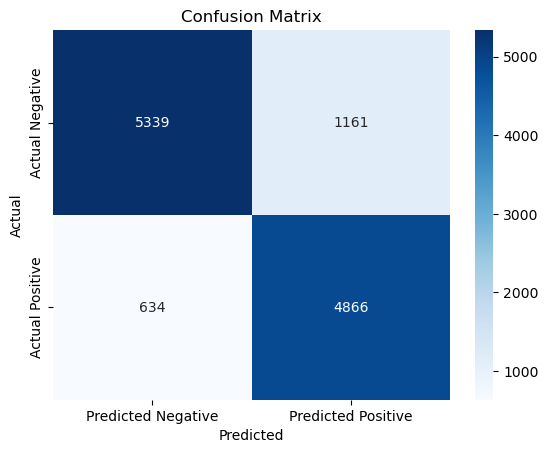

In [13]:
sns.heatmap(all_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Results Visualization

In [14]:
# printing training loss for each fold.
avg_train_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(train_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_train_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Train Loss = {}, Average Train Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Train Loss = 0.11769307180564555, Average Train Accuracy = 0.8823069281943544
Fold 2: Average Train Loss = 0.09855314681113425, Average Train Accuracy = 0.9014468531888657
Fold 3: Average Train Loss = 0.0939150801900142, Average Train Accuracy = 0.9060849198099858
Fold 4: Average Train Loss = 0.09817719265689567, Average Train Accuracy = 0.9018228073431043
Fold 5: Average Train Loss = 0.128612357611595, Average Train Accuracy = 0.871387642388405


In [15]:
# printing validation loss for each fold.
avg_val_loss_per_fold = []

for i in range(0, 5, +1):
    sumz = sum(val_loss_per_fold[i])
    avg_loss = sumz / 100
    avg_val_loss_per_fold.append(avg_loss)
    print("Fold {}: Average Validation Loss = {}, Average Validation Accuracy = {}".format(i+1, avg_loss, 1.0 - avg_loss))

Fold 1: Average Validation Loss = 0.35402630160951953, Average Validation Accuracy = 0.6459736983904805
Fold 2: Average Validation Loss = 0.5350546145690896, Average Validation Accuracy = 0.46494538543091035
Fold 3: Average Validation Loss = 0.3364212038638652, Average Validation Accuracy = 0.6635787961361348
Fold 4: Average Validation Loss = 0.25431531026388987, Average Validation Accuracy = 0.7456846897361101
Fold 5: Average Validation Loss = 0.1654513368441258, Average Validation Accuracy = 0.8345486631558742


In [16]:
# Printing test set accuracy for each fold.
for value in test_acc_per_fold:
    print(value)

80.66666666666666
83.50000000000001
92.41666666666666
79.75
88.875


In [17]:
# Average accuracy
np.mean(test_acc_per_fold)

85.04166666666667

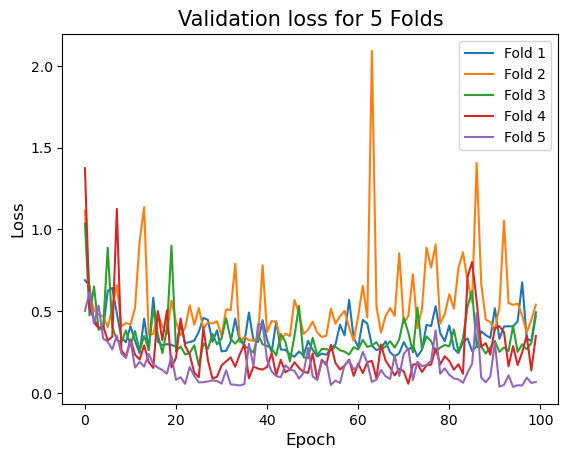

In [18]:
n_folds = len(val_loss_per_fold)
n_epochs = len(val_loss_per_fold[0])

# plot each fold's accuracy as a line plot with a different color
for i in range(n_folds):
    plt.plot(range(n_epochs), val_loss_per_fold[i], label=f"Fold {i+1}")

# set plot title, axis labels, and legend
plt.title("Validation loss for 5 Folds", fontsize = 15)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()

plt.show()

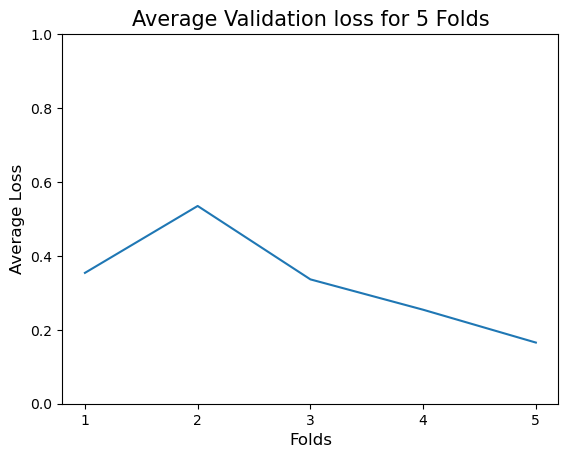

In [19]:
# Plotting the data
plt.plot(range(1, len(avg_val_loss_per_fold) + 1), avg_val_loss_per_fold)
plt.xticks(range(1, len(avg_val_loss_per_fold) + 1))

# Set y-axis range
plt.ylim(0, 1.0)

# Set plot title, axis labels, and legend
plt.title("Average Validation loss for 5 Folds", fontsize=15)
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Average Loss", fontsize=12)

# Display the plot
plt.show()

In [20]:
final_model_save_path = r'C:\Users\anikd\Desktop\NC_vs_PAE\final_model_aug_122scans_new_3.pth'
torch.save(modified_model.state_dict(), final_model_save_path)